In [21]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    precision_recall_curve
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To build classification models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For tuning the model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading files
path = '../../datasets/'

travel_train = pd.read_csv(path + 'Traveldata_train.csv')
survey_train = pd.read_csv(path + 'Surveydata_train.csv')
travel_test = pd.read_csv(path + 'Traveldata_test.csv')
survey_test = pd.read_csv(path + 'Surveydata_test.csv')

datasets = [travel_train,survey_train,travel_test,survey_test]

for df in datasets:
    print(df.shape)

(94379, 9)
(94379, 17)
(35602, 9)
(35602, 16)


In [3]:
# UDFs to clean input missing values and creating dummy variables
def fill_nas_with_mode(df, col):
    mode = df[col].mode().iloc[0]
    df[col].fillna(mode, inplace=True)

def fill_nas_with_median(df, col):
    median = df[col].median()
    df[col].fillna(median, inplace=True)
    
def merge_dfs(travel_df, survey_df):
    result_df = travel_df.merge(survey_df, how='outer', on='ID', indicator=True)
    return result_df
    
def cleaning_df(df):
    # segregating categorical columns from numerical columns
    cat_cols = df.describe(include='object').columns.tolist()
    num_cols = df.describe().columns.tolist()
    
    # filling missing values
    for col in cat_cols:
        fill_nas_with_mode(df, col)

    for col in num_cols:
        fill_nas_with_median(df, col)
        
    # getting dummies
    dumm_df = df.drop(columns=['ID','_merge'])
    dumm_df = pd.get_dummies(dumm_df, drop_first=True)
    
    # editing names of dummy columns
    dumm_df.columns = dumm_df.columns.str.strip()
    dumm_df.columns = dumm_df.columns.str.replace(' ', '_')
    
    return dumm_df

In [4]:
test_df = merge_dfs(travel_test,survey_test)
train_df = merge_dfs(travel_train,survey_train)

In [5]:
dumm_test_df = cleaning_df(test_df)
dumm_test_df.head()

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Gender_Male,Customer_Type_Loyal_Customer,Type_Travel_Personal_Travel,Travel_Class_Eco,Seat_Comfort_Excellent,Seat_Comfort_Extremely_Poor,...,CheckIn_Service_Poor,Cleanliness_Excellent,Cleanliness_Good,Cleanliness_Needs_Improvement,Cleanliness_Poor,Online_Boarding_Excellent,Online_Boarding_Extremely_Poor,Online_Boarding_Good,Online_Boarding_Needs_Improvement,Online_Boarding_Poor
0,36.0,532,0.0,0.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,21.0,1425,9.0,28.0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,60.0,2832,0.0,0.0,1,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,29.0,1352,0.0,0.0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
4,18.0,1610,17.0,0.0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [6]:
dumm_train_df = cleaning_df(train_df)
dumm_train_df.head()

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,Gender_Male,Customer_Type_Loyal_Customer,Type_Travel_Personal_Travel,Travel_Class_Eco,Seat_Comfort_Excellent,...,Cleanliness_Excellent,Cleanliness_Extremely_Poor,Cleanliness_Good,Cleanliness_Needs_Improvement,Cleanliness_Poor,Online_Boarding_Excellent,Online_Boarding_Extremely_Poor,Online_Boarding_Good,Online_Boarding_Needs_Improvement,Online_Boarding_Poor
0,52.0,272,0.0,5.0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,48.0,2200,9.0,0.0,0,1,1,1,1,0,...,0,0,1,0,0,0,0,1,0,0
2,43.0,1061,77.0,119.0,1,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,44.0,780,13.0,18.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50.0,1981,0.0,0.0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [7]:
cols_train = set(cleaning_df(train_df).columns.tolist())
cols_test = set(cleaning_df(test_df).columns.tolist())
missing_cols = list(cols_train - cols_test)
missing_cols

['Cleanliness_Extremely_Poor',
 'Online_Support_Extremely_Poor',
 'CheckIn_Service_Extremely_Poor',
 'Overall_Experience',
 'Platform_Location_Very_Inconvenient',
 'Onboard_Service_Extremely_Poor']

In [8]:
for col in missing_cols:
    dumm_test_df[col] = 0

# Model: Random Forest

* If the frequency of class A is 17% and the frequency of class B is 83%, then class B will become the dominant class and **the random forest will become biased toward the dominant class.**
* **class_weight is a hyperparameter** for the RandomForestClassifier. In this case, we can pass a dictionary {0:0.17, 1:0.83} to specify the weight of each class and the random forest will weight each class accordingly.

In [9]:
X = dumm_train_df.drop(columns='Overall_Experience')
y = dumm_train_df['Overall_Experience']

In [10]:
y.value_counts(normalize=True)

1    0.546658
0    0.453342
Name: Overall_Experience, dtype: float64

In [11]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [12]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(class_weight={0: 0.453, 1: 0.547}, random_state=1)

rf_estimator.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.453, 1: 0.547}, random_state=1)

## model evaluation

In [13]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Attrite', 'Attrite'], yticklabels=['Not Attrite', 'Attrite'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29950
           1       1.00      1.00      1.00     36115

    accuracy                           1.00     66065
   macro avg       1.00      1.00      1.00     66065
weighted avg       1.00      1.00      1.00     66065



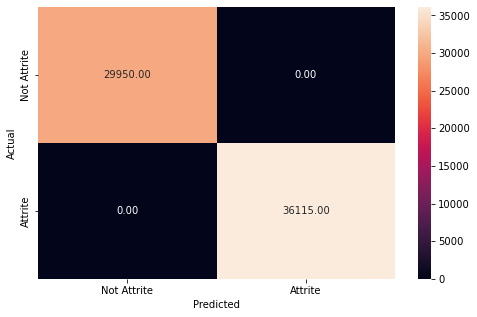

In [14]:
# Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(X_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     12836
           1       0.96      0.94      0.95     15478

    accuracy                           0.95     28314
   macro avg       0.95      0.95      0.95     28314
weighted avg       0.95      0.95      0.95     28314



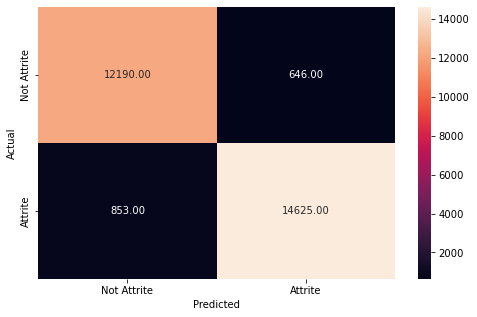

In [15]:
# Checking performance on the testing data
y_pred_test_rf = rf_estimator.predict(X_test)

metrics_score(y_test, y_pred_test_rf)

This random forest presents robust results since we get an accuracy of 95%.

<AxesSubplot:xlabel='Importance'>

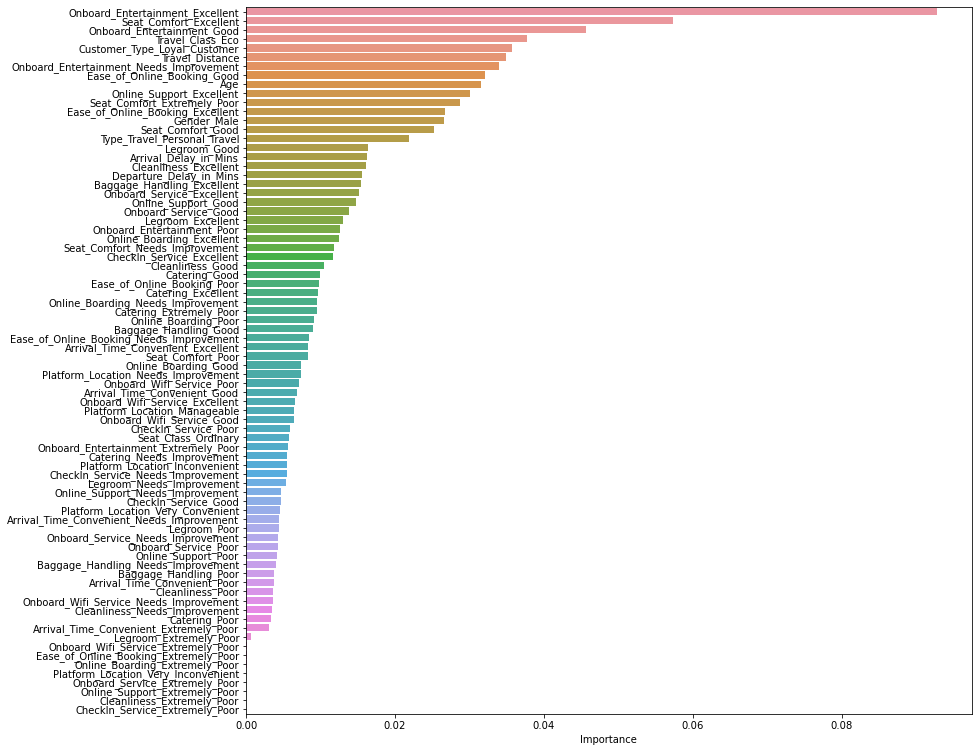

In [16]:
importances = rf_estimator.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance, importance_df.index)

# Fine tuning

## Random Search


In [55]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(class_weight={0: 0.453, 1: 0.547}, random_state=1)

# Grid of parameters to choose from
params_rf = {  
        "n_estimators": np.arange(200,501,50),
        "criterion":["gini", "entropy"],
        "max_depth":np.arange(10,31,5),
        "min_samples_leaf": np.arange(1,5,1),
        "max_features": ["sqrt", "log2"],
}

# Run the grid search
grid_obj = RandomizedSearchCV(rf_estimator_tuned, params_rf, scoring='accuracy', random_state=1, verbose=10, cv=2)

grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=4, n_estimators=400
[CV 1/2; 1/10] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=4, n_estimators=400;, score=0.930 total time=   8.5s
[CV 2/2; 1/10] START criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=4, n_estimators=400
[CV 2/2; 1/10] END criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=4, n_estimators=400;, score=0.929 total time=   8.7s
[CV 1/2; 2/10] START criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=2, n_estimators=500
[CV 1/2; 2/10] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=2, n_estimators=500;, score=0.941 total time=  12.6s
[CV 2/2; 2/10] START criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=2, n_estimators=500
[CV 2/2; 2/10] END criterion=entropy, max_depth=30, max_features=sqrt, min_s

In [57]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(class_weight={0: 0.453, 1: 0.547}, random_state=1)

# Grid of parameters to choose from
params_rf = {  
        "n_estimators": np.arange(100,401,100),
        "criterion":["gini"],
        "max_depth":np.arange(20,36,5),
        "min_samples_leaf": [1],
        "max_features": ["sqrt", "log2"],
}


# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring='accuracy', verbose=5, cv=2)

grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[CV 1/2] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, n_estimators=100;, score=0.941 total time=   2.5s
[CV 2/2] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, n_estimators=100;, score=0.941 total time=   2.5s
[CV 1/2] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, n_estimators=200;, score=0.941 total time=   4.9s
[CV 2/2] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, n_estimators=200;, score=0.941 total time=   4.8s
[CV 1/2] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, n_estimators=300;, score=0.942 total time=   7.3s
[CV 2/2] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, n_estimators=300;, score=0.941 total time=   7.3s
[CV 1/2] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, n_estimators=400;, score=0.942 total time=   9.8s
[CV 2/2] END c

[CV 1/2] END criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=2, n_estimators=400;, score=0.937 total time=   8.5s
[CV 2/2] END criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=2, n_estimators=400;, score=0.936 total time=34.9min
[CV 1/2] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, n_estimators=100;, score=0.943 total time=   2.6s
[CV 2/2] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, n_estimators=100;, score=0.942 total time=   2.6s
[CV 1/2] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, n_estimators=200;, score=0.943 total time=17.6min
[CV 2/2] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, n_estimators=200;, score=0.943 total time=16.1min
[CV 1/2] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, n_estimators=300;, score=0.943 total time= 2.2min
[CV 2/2] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_le

[CV 2/2] END criterion=gini, max_depth=35, max_features=log2, min_samples_leaf=2, n_estimators=300;, score=0.937 total time=   6.4s
[CV 1/2] END criterion=gini, max_depth=35, max_features=log2, min_samples_leaf=2, n_estimators=400;, score=0.937 total time=   8.5s
[CV 2/2] END criterion=gini, max_depth=35, max_features=log2, min_samples_leaf=2, n_estimators=400;, score=0.937 total time=   8.5s


In [58]:
rf_estimator_tuned

RandomForestClassifier(class_weight={0: 0.453, 1: 0.547}, max_depth=35,
                       max_features='sqrt', n_estimators=200, random_state=1)

In [68]:
rf_estimator_tuned = RandomForestClassifier(class_weight={0: 0.453, 1: 0.547},
                                            max_depth=35,
                                            max_features='sqrt', 
                                            n_estimators=400, 
                                            random_state=1,
                                           verbose=10)

rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.453, 1: 0.547}, max_depth=35,
                       max_features='sqrt', n_estimators=400, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29950
           1       1.00      1.00      1.00     36115

    accuracy                           1.00     66065
   macro avg       1.00      1.00      1.00     66065
weighted avg       1.00      1.00      1.00     66065



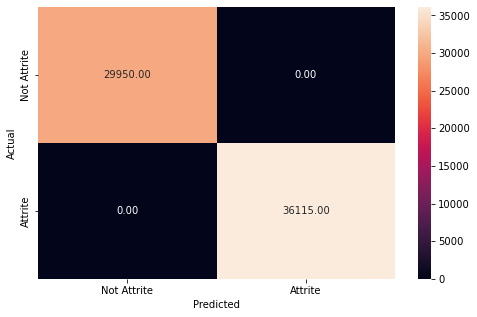

In [69]:
# Checking performance on the training data
y_pred_train_rf_tuned = rf_estimator_tuned.predict(X_train)

metrics_score(y_train, y_pred_train_rf_tuned)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     12836
           1       0.96      0.95      0.95     15478

    accuracy                           0.95     28314
   macro avg       0.95      0.95      0.95     28314
weighted avg       0.95      0.95      0.95     28314



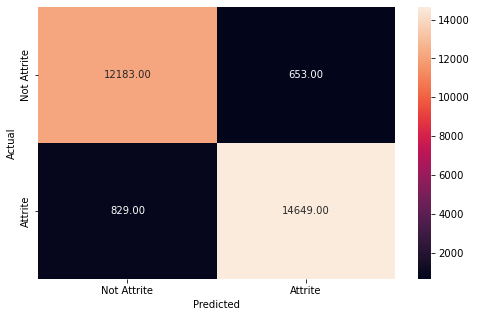

In [70]:
# Checking performance on the test data
y_pred_test_rf_tuned = rf_estimator_tuned.predict(X_test)

metrics_score(y_test, y_pred_test_rf_tuned)

# Submission

In [71]:
X = dumm_test_df.drop(columns='Overall_Experience')

In [72]:
preds = rf_estimator_tuned.predict(X)

In [73]:
submmission_df = pd.DataFrame(data = preds, 
                  index = test_df.ID.values, 
                  columns = ['Overall_Experience'])

submmission_df.rename_axis('ID', inplace=True)

submmission_df

,Overall_Experience
ID,
99900001,1
99900002,1
99900003,1
99900004,0
99900005,1
...,...
99935598,0
99935599,0
99935600,1


In [74]:
submmission_df.to_csv('submission4.csv')